# IDB_drilling_monitoring_lime

## Import packages

In [1]:
import gc
import IPython
import librosa
import lime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy.io as scio
import shap
import soundfile
import time
from keras.layers import Activation, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, Input, MaxPooling1D, MaxPooling2D
from keras.models import load_model, Model, Sequential
from keras.utils import to_categorical
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm import tqdm

!nvidia-smi

HOST_path = "/root/autodl-tmp"
SETS_path = os.path.join(HOST_path, "IDB_drilling_monitoring/datasets")
SAVE_path = os.path.join(HOST_path, "IDB_drilling_monitoring/lime")

if not os.path.exists(SAVE_path):
    os.makedirs(SAVE_path)

2023-10-24 14:31:36.617952: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Tue Oct 24 14:31:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:18:00.0 Off |                  Off |
| 30%   27C    P8    17W / 450W |      2MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import datasets

In [2]:
X_set = np.load(os.path.join(SETS_path, "X_set.npy"))
X_set_cnn = np.load(os.path.join(SETS_path, "X_set_cnn.npy"))
Y_set = np.load(os.path.join(SETS_path, "Y_set.npy"))

ALL7 = np.load(os.path.join(SETS_path, "ALL7.npy"))
ALL6 = np.load(os.path.join(SETS_path, "ALL6.npy"))
HEIGHT = np.load(os.path.join(SETS_path, "HEIGHT.npy"))
RPM = np.load(os.path.join(SETS_path, "RPM.npy"))
TORQUE = np.load(os.path.join(SETS_path, "TORQUE.npy"))
PUMPR = np.load(os.path.join(SETS_path, "PUMPR.npy"))
PUMPP = np.load(os.path.join(SETS_path, "PUMPP.npy"))
ROP = np.load(os.path.join(SETS_path, "ROP.npy"))
WOB = np.load(os.path.join(SETS_path, "WOB.npy"))

print(X_set.shape)
print(X_set_cnn.shape)
print(Y_set.shape)

print(ALL7.shape)
print(ALL6.shape)
print(HEIGHT.shape)
print(RPM.shape)
print(TORQUE.shape)
print(PUMPR.shape)
print(PUMPP.shape)
print(ROP.shape)
print(WOB.shape)

(35524, 12000)
(35524, 12000, 1)
(35524, 7)
(35524, 7)
(35524, 6)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)


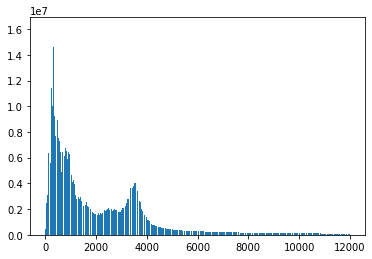

In [3]:
def distributionOf(arr):
    Freq = np.sum(arr, axis=0)
    plt.bar(np.arange(arr.shape[1]), Freq)
    plt.show()

distributionOf(X_set)

In [4]:
print(X_set.shape)
print(X_set)

(35524, 12000)
[[ 3.69545312 10.0336584   5.00140735 ...  3.62882899  1.9633871
   1.55529765]
 [ 4.46275059  9.47017867 10.35649324 ...  1.92746959  1.61736184
   3.70639905]
 [ 3.81786369 11.04322585 13.54993743 ...  2.82333739  1.30031815
   3.25870772]
 ...
 [10.7989744  12.70249237 13.64979581 ...  0.12924805  0.30560761
   0.07823928]
 [ 5.84249246  3.35302212  6.99121709 ...  0.23678803  0.12476213
   0.14811056]
 [ 0.85414921  3.55850481  2.23368328 ...  0.34487924  0.45839801
   0.18501066]]


In [5]:
X_set = X_set[:,0:6000]
print(X_set.shape)
print(X_set)

(35524, 6000)
[[ 3.69545312 10.0336584   5.00140735 ... 14.44039315  6.0906192
  23.99444889]
 [ 4.46275059  9.47017867 10.35649324 ... 26.00957373  7.68744846
  12.18294073]
 [ 3.81786369 11.04322585 13.54993743 ... 24.95938579 11.70737171
   9.19468604]
 ...
 [10.7989744  12.70249237 13.64979581 ...  4.13771624  5.77013574
   2.62698451]
 [ 5.84249246  3.35302212  6.99121709 ...  2.68119829  2.76544012
   1.85993352]
 [ 0.85414921  3.55850481  2.23368328 ...  5.56349666  7.84796724
   6.69374229]]


### Group

In [6]:
DATA = "RPM"

In [7]:
# DATA_path = os.path.join(HOST_path, "IDB_drilling_monitoring/evaluation/"+DATA)

# if not os.path.exists(DATA_path):
#     os.makedirs(DATA_path)
    
# model = load_model(os.path.join(HOST_path, "IDB_drilling_monitoring/outputs_"+DATA+"/best_model.hdf5"))

In [8]:
INPUT = X_set
OUTPUT = eval(DATA)

if OUTPUT.ndim == 1:
    num_targets = 1
else:
    num_targets = OUTPUT.shape[1]

print(INPUT.shape)
print(OUTPUT.shape)
print(num_targets)

(35524, 6000)
(35524,)
1


### DATA

In [9]:
# X = pd.DataFrame(data=INPUT, columns=[f"{i}Hz" for i in range(1, INPUT.shape[1]+1)])
# y = OUTPUT

# print(type(X), X.shape)
# print(type(y), y.shape)

In [10]:
# print(X)
# print(y)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(INPUT, OUTPUT, test_size=0.2, random_state=42, shuffle=True)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(28419, 6000)
(28419,)
(7105, 6000)
(7105,)


### Model

#### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)

print("Test R^2 Score  : ", lr.score(X_test, Y_test))
print("Train R^2 Score : ", lr.score(X_train, Y_train))

Test R^2 Score  :  0.9432630304260193
Train R^2 Score :  0.9670299198627075


In [20]:
feature_names = [f"{i}Hz" for i in range(1, INPUT.shape[1]+1)]
print(feature_names[:10])
print(feature_names[-10:])

['1Hz', '2Hz', '3Hz', '4Hz', '5Hz', '6Hz', '7Hz', '8Hz', '9Hz', '10Hz']
['5991Hz', '5992Hz', '5993Hz', '5994Hz', '5995Hz', '5996Hz', '5997Hz', '5998Hz', '5999Hz', '6000Hz']


In [21]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train, mode="regression", feature_names= feature_names)
explainer

In [22]:
idx = random.randint(1, len(X_test))

print("Prediction : ", lr.predict(X_test[idx].reshape(1,-1)))
print("Actual :     ", Y_test[idx])

Prediction :  [402.56050384]
Actual :      403.0


In [23]:
explanation = explainer.explain_instance(X_test[idx], lr.predict, num_features=len(feature_names))
explanation

In [ ]:
# explanation.show_in_notebook()

In [ ]:
# with plt.style.context("ggplot"):
#     explanation.as_pyplot_figure()

In [27]:
print("Explanation Local Prediction  : ", explanation.local_pred)
print("Explanation Global Prediction : ", explanation.predicted_value)

Explanation Local Prediction  :  [402.44853375]
Explanation Global Prediction :  402.5605038440573


#### Decision Tree

In [ ]:
from sklearn import tree

In [ ]:
dtree = tree.DecisionTreeRegressor(min_samples_split=20)

In [ ]:
dtree.fit(X_train, y_train)

In [ ]:
print_accuracy(dtree.predict)

In [ ]:
# explain all the predictions in the test set
ex = shap.TreeExplainer(dtree)

In [ ]:
shap_values = ex.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot("bmi", shap_values, X_test)

In [ ]:
shap.force_plot(ex.expected_value, shap_values, X_test)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rforest = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=2, random_state=42)

In [ ]:
rforest.fit(X_train, y_train)

In [ ]:
print_accuracy(rforest.predict)

In [ ]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rforest)

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)